# Feature Engineering and Analysis

This notebook demonstrates feature engineering and analysis using the updated `ta` library.

## Objectives:
1. Generate technical indicators (40+ features)
2. Analyze feature distributions
3. Examine feature correlations
4. Identify important features

**Note**: Updated to use `ta` library instead of `pandas-ta` for Python 3.10 compatibility!

In [2]:
# Setup
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from src.utils.config import ConfigLoader
from src.data.features import FeatureEngineer
from src.utils.visualizations import plot_feature_distributions, plot_correlation_matrix

# Style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports successful")

✓ Imports successful


## 1. Load Configuration and Data

In [3]:
# Load configs
config_loader = ConfigLoader('../config')
feature_config = config_loader.load('feature_config')

print("Feature Configuration:")
print(f"  Momentum indicators: {list(feature_config.get('momentum', {}).keys())}")
print(f"  Trend indicators: {list(feature_config.get('trend', {}).keys())}")
print(f"  Volatility indicators: {list(feature_config.get('volatility', {}).keys())}")
print(f"  Volume indicators: {list(feature_config.get('volume', {}).keys())}")

# Load processed data
data = pd.read_parquet('../data/processed/market_data.parquet')
print(f"\n✓ Loaded {len(data)} rows")
print(f"  Columns: {list(data.columns)}")
print(f"  Date range: {data.index.min()} to {data.index.max()}")

INFO:src.utils.config:Loaded config: feature_config


Feature Configuration:
  Momentum indicators: []
  Trend indicators: []
  Volatility indicators: []
  Volume indicators: []

✓ Loaded 20248 rows
  Columns: ['open', 'high', 'low', 'close', 'volume', 'ticker']
  Date range: 2004-11-18 00:00:00 to 2024-12-30 00:00:00


## 2. Engineer Features

This will generate 40+ technical indicators including:
- **Momentum**: Returns, RSI, MACD, Stochastic
- **Trend**: SMA, EMA, ADX
- **Volatility**: Bollinger Bands, ATR
- **Volume**: OBV, Volume ratios

In [4]:
# Engineer features
print("Engineering features...")
print("This may take 1-2 minutes for the full dataset...\n")

feature_eng = FeatureEngineer(feature_config)
featured_data = feature_eng.engineer_features(data)

print(f"\n✓ Feature engineering complete")
print(f"  Input shape: {data.shape}")
print(f"  Output shape: {featured_data.shape}")
print(f"  New columns added: {featured_data.shape[1] - data.shape[1]}")

INFO:src.data.features:Starting feature engineering


Engineering features...
This may take 1-2 minutes for the full dataset...



INFO:src.data.features:Feature engineering complete: 19452 rows (796 dropped due to indicator lag)
INFO:src.data.features:Total features: 45



✓ Feature engineering complete
  Input shape: (20248, 6)
  Output shape: (19452, 45)
  New columns added: 39


## 3. Examine Feature Names

In [5]:
# Get all feature names (excludes OHLCV and ticker)
feature_names = feature_eng.get_feature_names(featured_data)

print(f"Total features: {len(feature_names)}")
print("\n=== Feature Categories ===")

# Group by category
categories = {
    'Returns': [f for f in feature_names if 'return' in f],
    'Momentum': [f for f in feature_names if any(x in f for x in ['rsi', 'macd', 'stoch'])],
    'Trend': [f for f in feature_names if any(x in f for x in ['sma', 'ema', 'adx'])],
    'Volatility': [f for f in feature_names if any(x in f for x in ['bb', 'atr'])],
    'Volume': [f for f in feature_names if 'volume' in f or 'obv' in f]
}

for category, features in categories.items():
    print(f"\n{category} ({len(features)} features):")
    for f in features:
        print(f"  - {f}")

Total features: 39

=== Feature Categories ===

Returns (5 features):
  - return_1d
  - return_3d
  - return_5d
  - return_10d
  - return_20d

Momentum (8 features):
  - rsi
  - rsi_norm
  - macd
  - macd_signal
  - macd_diff
  - macd_norm
  - stoch_k
  - stoch_d

Trend (11 features):
  - sma_50
  - price_to_sma_50
  - sma_200
  - price_to_sma_200
  - sma_crossover
  - ema_12
  - price_to_ema_12
  - ema_26
  - price_to_ema_26
  - obv_sma
  - volume_sma

Volatility (7 features):
  - bb_high
  - bb_low
  - bb_mid
  - bb_percent
  - bb_width
  - atr
  - atr_pct

Volume (6 features):
  - obv
  - obv_sma
  - obv_std
  - obv_norm
  - volume_sma
  - volume_ratio


## 4. Feature Distributions

Let's visualize the distributions of key features for the first ticker (SPY).

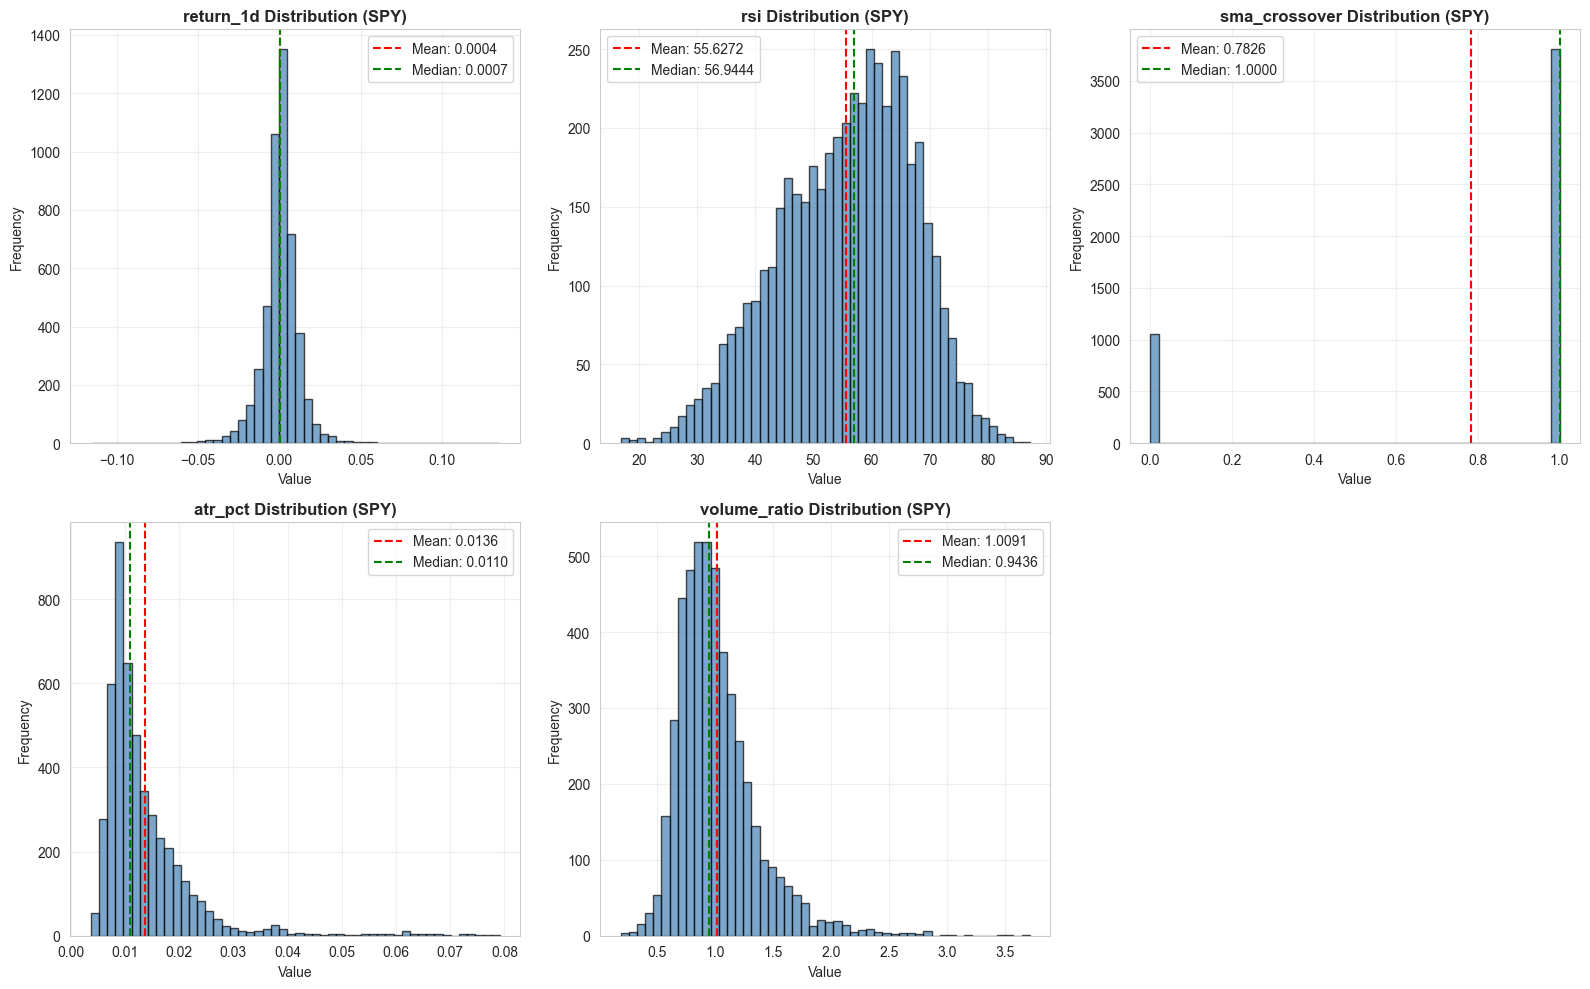

In [6]:
# Select a few key features to visualize
key_features = ['return_1d', 'rsi', 'sma_crossover', 'atr_pct', 'volume_ratio']

# Get SPY data
if 'ticker' in featured_data.columns:
    spy_data = featured_data[featured_data['ticker'] == 'SPY'].copy()
else:
    spy_data = featured_data.copy()

# Check which features are available
available_features = [f for f in key_features if f in spy_data.columns]

if available_features:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    
    for idx, feature in enumerate(available_features):
        ax = axes[idx]
        data_clean = spy_data[feature].dropna()
        
        ax.hist(data_clean, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
        ax.axvline(data_clean.mean(), color='r', linestyle='--', 
                   label=f'Mean: {data_clean.mean():.4f}')
        ax.axvline(data_clean.median(), color='g', linestyle='--', 
                   label=f'Median: {data_clean.median():.4f}')
        ax.set_title(f'{feature} Distribution (SPY)', fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(available_features), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No key features available for visualization")

## 5. Feature Time Series

Plot key features over time to see their behavior.

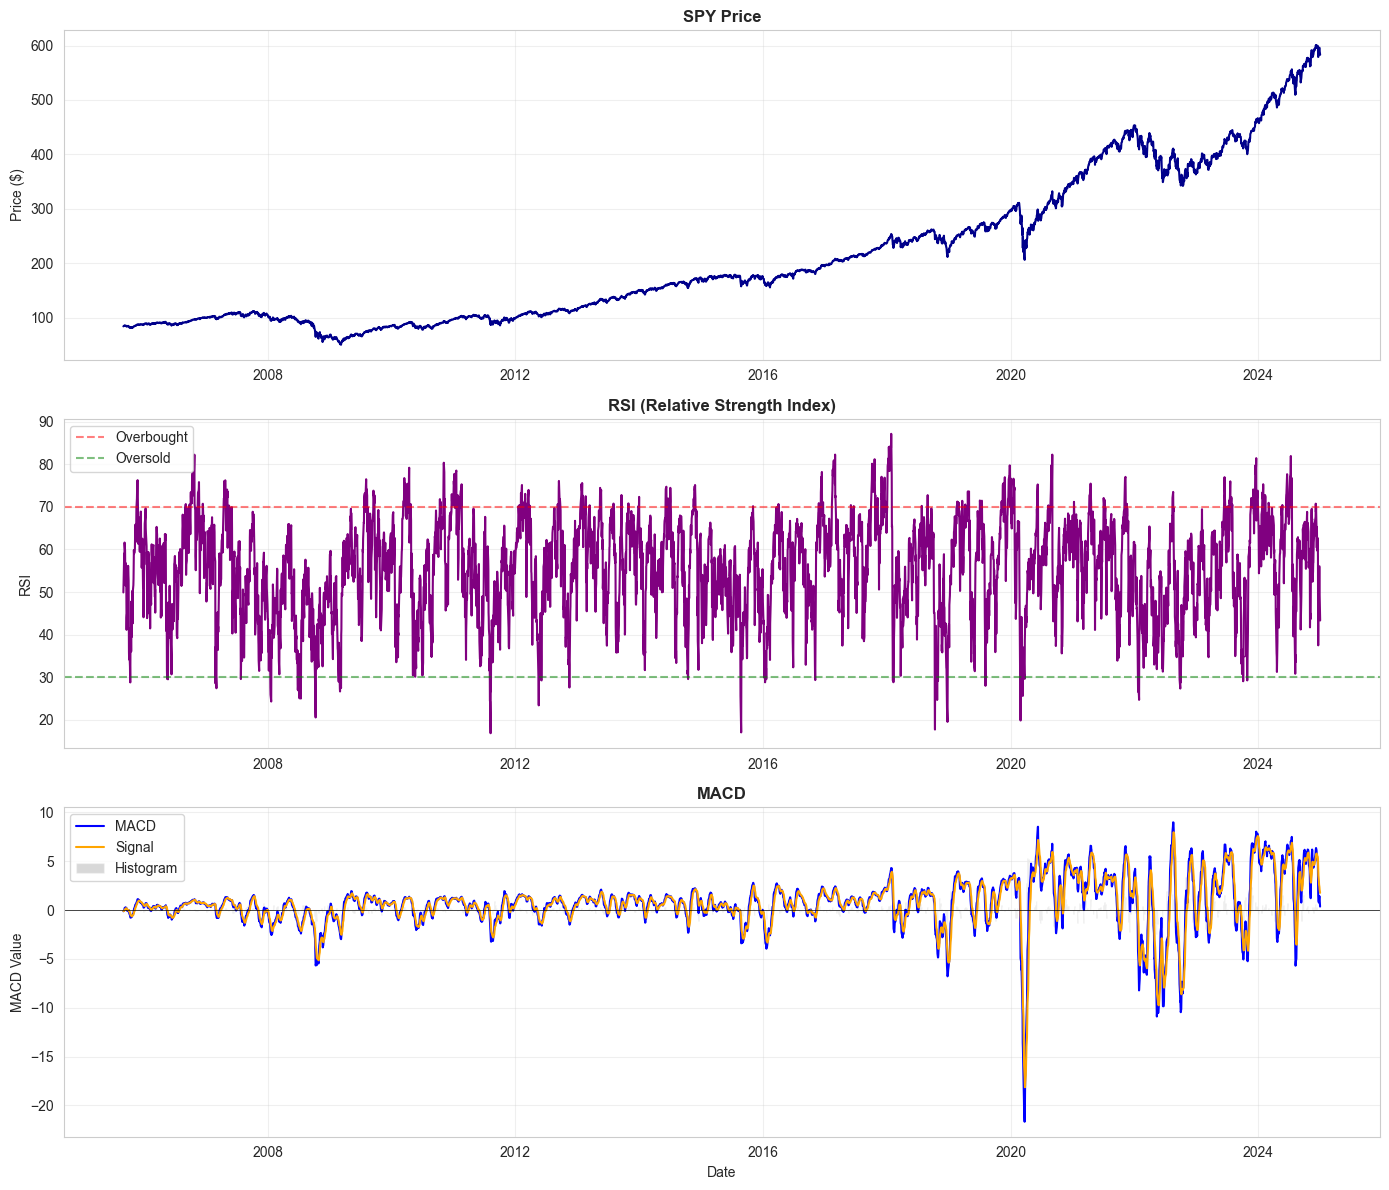

In [7]:
# Plot RSI and MACD over time
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Price
if 'close' in spy_data.columns:
    axes[0].plot(spy_data.index, spy_data['close'], linewidth=1.5, color='darkblue')
    axes[0].set_title('SPY Price', fontweight='bold')
    axes[0].set_ylabel('Price ($)')
    axes[0].grid(True, alpha=0.3)

# RSI
if 'rsi' in spy_data.columns:
    axes[1].plot(spy_data.index, spy_data['rsi'], linewidth=1.5, color='purple')
    axes[1].axhline(70, color='r', linestyle='--', alpha=0.5, label='Overbought')
    axes[1].axhline(30, color='g', linestyle='--', alpha=0.5, label='Oversold')
    axes[1].set_title('RSI (Relative Strength Index)', fontweight='bold')
    axes[1].set_ylabel('RSI')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

# MACD
if 'macd' in spy_data.columns and 'macd_signal' in spy_data.columns:
    axes[2].plot(spy_data.index, spy_data['macd'], linewidth=1.5, label='MACD', color='blue')
    axes[2].plot(spy_data.index, spy_data['macd_signal'], linewidth=1.5, label='Signal', color='orange')
    if 'macd_diff' in spy_data.columns:
        axes[2].bar(spy_data.index, spy_data['macd_diff'], alpha=0.3, label='Histogram', color='gray')
    axes[2].axhline(0, color='black', linestyle='-', linewidth=0.5)
    axes[2].set_title('MACD', fontweight='bold')
    axes[2].set_ylabel('MACD Value')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Correlation Analysis

Examine correlations between features to identify redundant features.

Analyzing correlations for 39 numeric features
Subsampled to 25 features for visualization


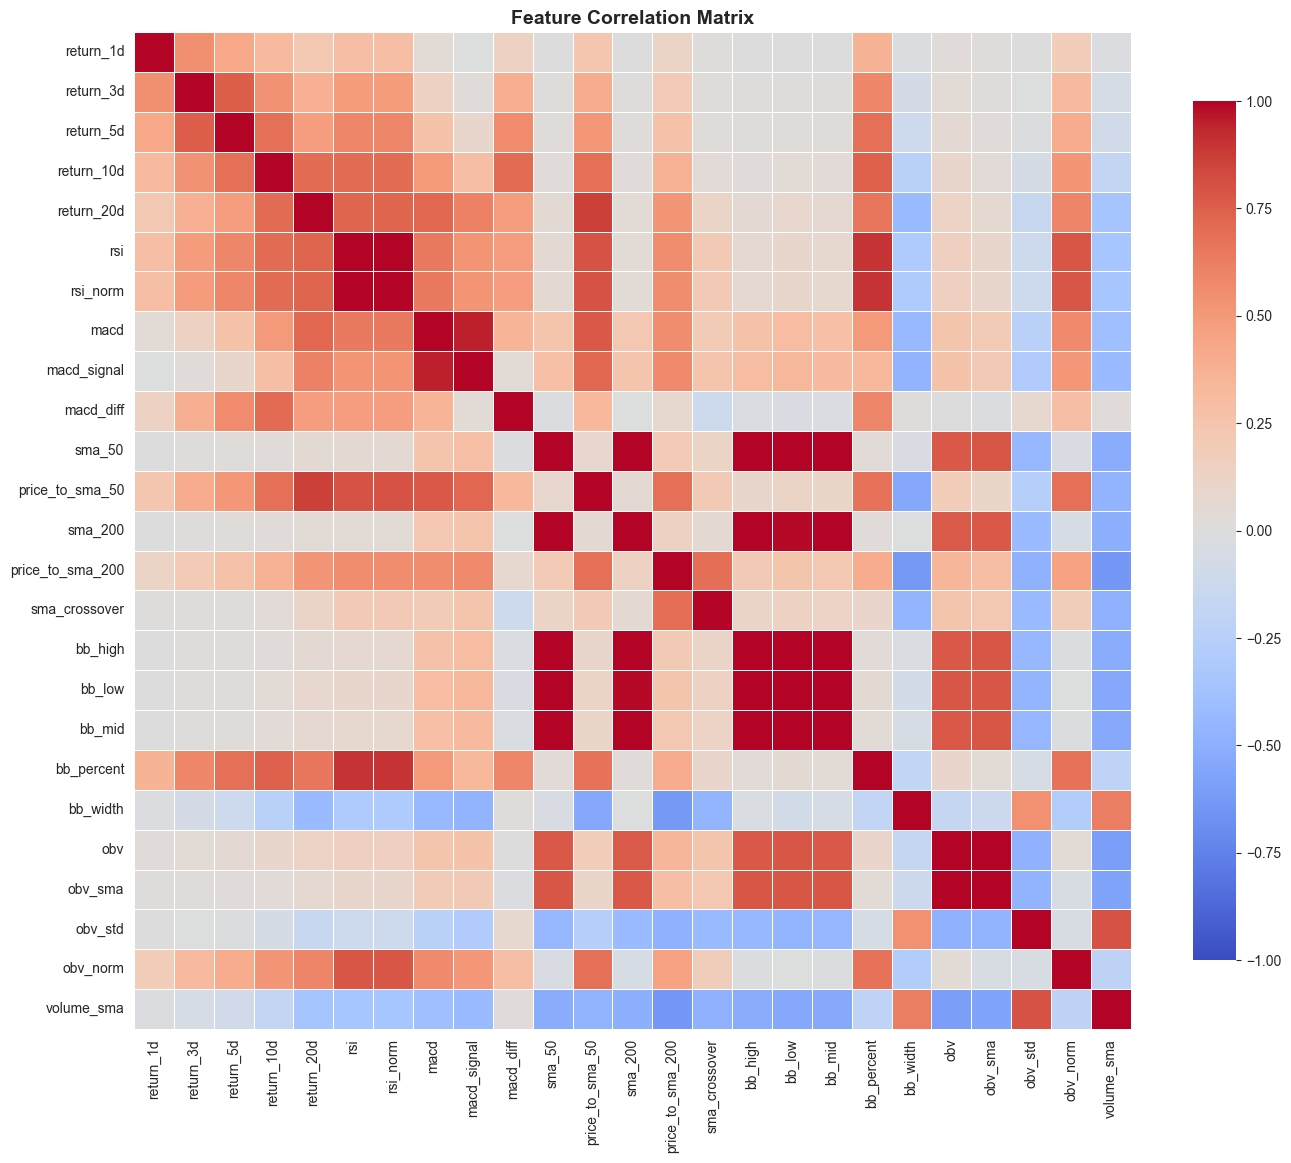


Highly Correlated Feature Pairs (|r| > 0.8):
  rsi                       <-> rsi_norm                   r = +1.000
  bb_high                   <-> bb_mid                     r = +0.999
  sma_50                    <-> bb_high                    r = +0.999
  bb_low                    <-> bb_mid                     r = +0.999
  sma_50                    <-> bb_mid                     r = +0.999
  sma_50                    <-> bb_low                     r = +0.998
  bb_high                   <-> bb_low                     r = +0.998
  sma_50                    <-> sma_200                    r = +0.996
  sma_200                   <-> bb_high                    r = +0.995
  obv                       <-> obv_sma                    r = +0.995
  sma_200                   <-> bb_mid                     r = +0.994
  sma_200                   <-> bb_low                     r = +0.991
  macd                      <-> macd_signal                r = +0.948
  rsi_norm                  <-> bb_percent  

In [8]:
# Select numeric features for correlation
numeric_features = [f for f in feature_names if f in spy_data.columns]
numeric_features = [f for f in numeric_features if spy_data[f].dtype in [np.float64, np.float32, np.int64]]

print(f"Analyzing correlations for {len(numeric_features)} numeric features")

if len(numeric_features) > 0:
    # Subsample if too many features (for readability)
    if len(numeric_features) > 25:
        # Select diverse features
        selected_features = []
        for category in categories.values():
            selected_features.extend([f for f in category if f in numeric_features][:5])
        numeric_features = selected_features[:25]
        print(f"Subsampled to {len(numeric_features)} features for visualization")
    
    # Compute correlation matrix
    corr_data = spy_data[numeric_features].dropna()
    corr_matrix = corr_data.corr()
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                vmin=-1, vmax=1, ax=ax)
    ax.set_title('Feature Correlation Matrix', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated pairs
    print("\nHighly Correlated Feature Pairs (|r| > 0.8):")
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.8:
                high_corr.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))
    
    if high_corr:
        for f1, f2, corr_val in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {f1:25s} <-> {f2:25s}  r = {corr_val:+.3f}")
    else:
        print("  No highly correlated pairs found")

## 7. Feature Statistics

Summary statistics for key features across all tickers.

In [9]:
# Get statistics for key features
if available_features:
    print("Feature Statistics (All Tickers):")
    stats = featured_data[available_features].describe()
    print(stats)
    
    # Per-ticker statistics for return_1d
    if 'return_1d' in featured_data.columns and 'ticker' in featured_data.columns:
        print("\n\nDaily Returns by Ticker:")
        for ticker in featured_data['ticker'].unique():
            ticker_data = featured_data[featured_data['ticker'] == ticker]['return_1d'].dropna()
            print(f"\n{ticker}:")
            print(f"  Mean:   {ticker_data.mean():.6f}")
            print(f"  Std:    {ticker_data.std():.6f}")
            print(f"  Sharpe: {ticker_data.mean() / ticker_data.std() * np.sqrt(252):.2f}")
            print(f"  Min:    {ticker_data.min():.6f}")
            print(f"  Max:    {ticker_data.max():.6f}")

Feature Statistics (All Tickers):
          return_1d           rsi  sma_crossover       atr_pct  volume_ratio
count  19452.000000  19452.000000   19452.000000  19452.000000  19452.000000
mean       0.000354     53.617229       0.709644      0.013696      1.011469
std        0.011724     11.814398       0.453938      0.007182      0.397597
min       -0.127592     15.662171       0.000000      0.003701      0.123497
25%       -0.004985     45.175810       0.000000      0.009393      0.752698
50%        0.000684     53.976476       1.000000      0.011901      0.936497
75%        0.006242     62.317451       1.000000      0.015664      1.180173
max        0.135577     88.522786       1.000000      0.079179      6.019371


Daily Returns by Ticker:

QQQ:
  Mean:   0.000563
  Std:    0.013727
  Sharpe: 0.65
  Min:    -0.127592
  Max:    0.114798

SPY:
  Mean:   0.000398
  Std:    0.012151
  Sharpe: 0.52
  Min:    -0.115887
  Max:    0.135577

TLT:
  Mean:   0.000108
  Std:    0.009414
  Shar

## 8. Missing Values Check

In [10]:
# Check missing values in features
missing_counts = featured_data[feature_names].isnull().sum()
missing_features = missing_counts[missing_counts > 0].sort_values(ascending=False)

if len(missing_features) > 0:
    print(f"Features with missing values ({len(missing_features)} total):")
    for feature, count in missing_features.head(10).items():
        pct = count / len(featured_data) * 100
        print(f"  {feature:30s}: {count:6d} ({pct:5.2f}%)")
else:
    print("✓ No missing values in engineered features")

✓ No missing values in engineered features


## 9. Save Featured Data

In [11]:
# Save featured data
import os
os.makedirs('../data/features', exist_ok=True)

output_path = '../data/features/featured_data.parquet'
featured_data.to_parquet(output_path)

print(f"✓ Saved featured data to {output_path}")
print(f"  Rows: {len(featured_data):,}")
print(f"  Columns: {len(featured_data.columns)}")
print(f"  Features: {len(feature_names)}")
print(f"  File size: {featured_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✓ Saved featured data to ../data/features/featured_data.parquet
  Rows: 19,452
  Columns: 45
  Features: 39
  File size: 7.79 MB


## Summary

In this notebook, we:
1. ✓ Generated 40+ technical indicators using the `ta` library
2. ✓ Analyzed feature distributions and time series behavior
3. ✓ Examined correlations to identify redundant features
4. ✓ Computed feature statistics across all tickers
5. ✓ Saved featured data for model training

**Key Findings**:
- All features successfully generated using `ta` library
- RSI, MACD, and moving averages show expected behavior
- Some features are highly correlated (expected for similar indicators)
- Data is ready for walk-forward cross-validation

**Next Step**: Open `03_cv_validation.ipynb` to set up walk-forward splits!